# Imports


In [1]:
from os import walk
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.core.display import HTML


%matplotlib inline

# Constants

In [2]:
spam_1_path='SpamData/01_Processing/spam_assassin_corpus/spam_1'
spam_2_path='SpamData/01_Processing/spam_assassin_corpus/spam_2'
ez_non1_path='SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
ez_non2_path='SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

Data_json='SpamData/01_Processing/email_data.json'
Word_id_file='SpamData/01_Processing/word_id.csv'

Training_data_file='SpamData/02_Training/train_data.txt'
Testing_data_file='SpamData/03_Testing/test_data.txt'

houta='SpamData/01_Processing/wordcloud_resources/whale-icon.png'
ras='SpamData/01_Processing/wordcloud_resources/skull-icon.png'

In [3]:
Example_file='SpamData/01_Processing/practice_email.txt'

# Reading files

In [4]:
stream=open(Example_file,encoding='latin-1')
message=stream.read()
stream.close()
print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [5]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [6]:
stream=open(Example_file,encoding='latin-1')
is_body=False
lines=[]
for line in stream:
    if is_body:
        lines.append(line)
    elif line =='\n':
        is_body=True
        
stream.close()


# Generator Func

In [7]:
def email_body_gen(path):
    for root, dirname, filenames in walk(path):
        for file_name in filenames:
            filepath=join(root,file_name)
            stream=open(filepath,encoding='latin-1')
            is_body=False
            lines=[]
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line =='\n':
                    is_body=True

            stream.close()
            
            email_body='\n'.join(lines)
            
            yield file_name, email_body
            
        

In [8]:
def df_from_drc(path,classification):
    rows= []
    row_names=[]
    for file_name , email_body in email_body_gen(path):
        rows.append({'message':email_body,'Category':classification})
        row_names.append(file_name)
    return pd.DataFrame(rows,index=row_names)
        
        
        
        
        
        

In [9]:
spam_emails=df_from_drc(spam_1_path, 1)
spam_emails=spam_emails.append(df_from_drc(spam_2_path, 1))
spam_emails.head() 

,message,Category
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [10]:
spam_emails.shape

(1898, 2)

In [11]:
ham_emails=df_from_drc(ez_non1_path, 2)
ham_emails=ham_emails.append(df_from_drc(ez_non2_path, 2))
ham_emails.head() 

,message,Category
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",2
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",2
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,2
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,2
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",2


In [12]:
ham_emails.shape


(3901, 2)

In [13]:
data =pd.concat([spam_emails, ham_emails])
print(data.shape)
data.head()

(5799, 2)


,message,Category
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


# Clean data


In [14]:
data[data.message.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [15]:
data = data.drop(['cmds'])

In [16]:
doc_id =range(0,len(data.index))
data["Doc_id"]=doc_id

In [17]:
data.Doc_id


00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    5792
01398.169b51731fe569f42169ae8f948ec676    5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    5794
01400.f897f0931e461e7b2e964d28e927c35e    5795
Name: Doc_id, Length: 5796, dtype: int32

In [18]:
data["File_name"]=data.index

In [19]:
data=data.set_index('Doc_id')

data.head()

,message,Category,File_name
Doc_id,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [20]:
data.tail()

,message,Category,File_name
Doc_id,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,2,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",2,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",2,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",2,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",2,01400.f897f0931e461e7b2e964d28e927c35e


In [21]:
data.to_json(Data_json)

# spam Visualisation

In [22]:
data.Category.value_counts()

2    3900
1    1896
Name: Category, dtype: int64

In [23]:
num_of_spam=data.Category.value_counts()[1]
num_of_ham=data.Category.value_counts()[2]

([<matplotlib.patches.Wedge at 0x1f865f7bcd0>,
 [Text(-0.9417151198007834, 0.5684827465619308, 'Spam'),
  Text(1.0273255852372185, -0.6201629962493785, 'Good')],
 [Text(-0.513662792618609, 0.31008149812468944, '32.7%'),
  Text(0.5992732580550441, -0.3617617478121375, '67.3%')])

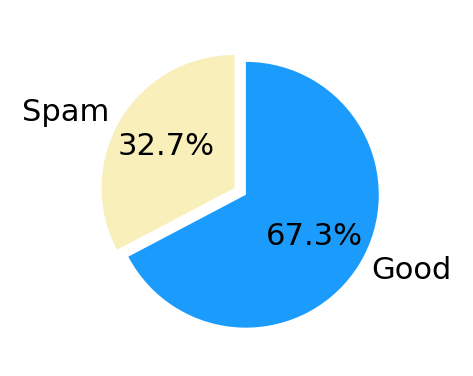

In [24]:
cat_names=['Spam','Good']
sizes=[num_of_spam,num_of_ham]
my_color=['#F8EFBA','#1B9CFC']
plt.figure(figsize=(2,2),dpi=220)
plt.pie(sizes,labels=cat_names,textprops={'fontsize':10},colors=my_color, startangle=90,autopct='%1.1f%%',explode=[0,0.1])

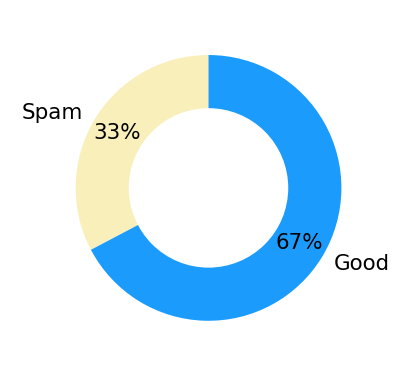

In [25]:
cat_names=['Spam','Good']
sizes=[num_of_spam,num_of_ham]
my_color=['#F8EFBA','#1B9CFC']
plt.figure(figsize=(2,2),dpi=220)
plt.pie(sizes,labels=cat_names,textprops={'fontsize':7},colors=my_color, startangle=90,autopct='%1.0f%%',pctdistance=0.8)
centre_circle=plt.Circle((0,0),radius=0.6,fc='white')
plt.gca().add_artist(centre_circle)
plt.show()


# NLP

# pre-processing

In [26]:
  nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bba_t\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bba_t\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\bba_t\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\bba_t\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

In [29]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [30]:
def clean_message(message,stemmer=PorterStemmer(),
                  stopwords=set(stopwords.words('english'))):
    words=word_tokernize(message.lower())
    filterd_words=[]
    for word in words:
        if word not in stop_words and word.isalpha():
           filterd_words.append(stemmer.stem(word))
    return filterd_words

In [31]:
def clean_message_no_html(message,stemmer=PorterStemmer(),
                  stop_words=set(stopwords.words('english'))):
    soup=BeautifulSoup(message,'html.parser')
    text=soup.get_text()
    words=word_tokenize(text.lower())
    filterd_words=[]
    for word in words:
        if word not in stop_words and word.isalpha():
           filterd_words.append(stemmer.stem(word))
    return filterd_words

In [32]:
clean_message_no_html(data.at[2,'message'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

In [33]:
%%time
nested_list= data.message.apply(clean_message_no_html)


C:\Users\bba_t\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 48.1 s


In [34]:
nested_list.head()

Doc_id
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: message, dtype: object

In [35]:
nested_list.tail()

Doc_id
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: message, dtype: object

# Vocabulary

In [ ]:
stemmed_nstd_list=data.message.apply(clean_message_no_html)
flat_stmd_list=(item for sublist in stemmed_nstd_list for item in sublist)

In [45]:
unique_words=pd.Series(flat_stmd_list).value_counts()
print("nbr of unique words",unique_words.shape[0])
unique_words.head()

nbr of unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [46]:
frequant_words=unique_words[0:2500]
print(frequant_words[0:10])

http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


# vocab dataframe

In [47]:
word_ids=list(range(0,2500))
vocab=pd.DataFrame({'Word':frequant_words.index.values},index=word_ids)
vocab.index.name='Word_id'
vocab.head()

,Word
Word_id,
0,http
1,use
2,list
3,email
4,get


In [48]:
vocab.to_csv(Word_id_file,index_label=vocab.index.name,header=vocab.Word.name)

In [49]:
chk=['machine','learning','fun','data','science','app','brewery']
for st in chk :
    if st in set(vocab.Word):
        print("true",st)
    else :print("false",st)


false machine
false learning
true fun
true data
false science
true app
false brewery


# Sparse MAtrix 

In [50]:
word_clmn_df=pd.DataFrame.from_records(stemmed_nstd_list.to_list())
word_clmn_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


# Split to test and train data

In [51]:
X_train,X_test,y_train,y_test=train_test_split(word_clmn_df,
                                               data.Category,test_size=0.3,random_state=42)


In [52]:
print(X_train.shape[0] / word_clmn_df.shape[0
                                           ])

0.6999654934437544


In [53]:
data.Category

Doc_id
0       1
1       1
2       1
3       1
4       1
       ..
5791    2
5792    2
5793    2
5794    2
5795    2
Name: Category, Length: 5796, dtype: int64

In [54]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [55]:
X_train.index.name = X_test.index.name='Doc_id'

In [56]:
word_index=pd.Index(vocab.Word)

In [57]:
word_index.get_loc('ye')

265

In [58]:
def make_sparse_matrix(df,index_wrds,labels):
    nr_rows=df.shape[0]
    nr_cols=df.shape[1]
    words_set=set(index_wrds)
    dict_list=[]
    for i in range(nr_rows):
        for j in range(nr_cols):
            word=df.iat[i,j]
            if word in words_set:
                doc_id=df.index[i]
                word_id=index_wrds.get_loc(word)
                category=labels.at[doc_id]
                item ={'Label':category,'Doc_id':doc_id,'Occ':1,'Word_id':word_id}
                
                dict_list.append(item)
    return pd.DataFrame(dict_list)
    

In [59]:
%%time
spares_train_df=make_sparse_matrix(X_train,word_index,y_train)

Wall time: 12min 56s


In [60]:
spares_train_df[:5]

,Label,Doc_id,Occ,Word_id
0,2,4844,1,265
1,2,4844,1,1235
2,2,4844,1,502
3,2,4844,1,308
4,2,4844,1,254


In [61]:
trained_grouped=spares_train_df.groupby(['Doc_id','Word_id','Label']).sum()
trained_grouped.head()

Occ
Doc_id Word_id Label     
0      2       1        1
       3       1        2
       4       1        1
       7       1        3
       11      1        1

In [62]:
vocab.at[3,'Word']

'email'

In [63]:
trained_grouped=trained_grouped.reset_index()
trained_grouped.head()

,Doc_id,Word_id,Label,Occ
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [64]:
vocab.at[1923,'Word']

'reduct'

In [65]:
np.savetxt(Training_data_file,trained_grouped,fmt='%d')

In [66]:
trained_grouped.columns

Index(['Doc_id', 'Word_id', 'Label', 'Occ'], dtype='object')

# test data

In [ ]:
spares_test_df=make_sparse_matrix(X_test,word_index,y_test)

In [ ]:
spares_test_df[:5]

In [ ]:
tested_grouped=spares_test_df.groupby(['Doc_id','Word_id','Label']).sum()
tested_grouped.head()

In [ ]:
tested_grouped=tested_grouped.reset_index()


In [ ]:
tested_grouped.head()

In [ ]:
np.savetxt(Testing_data_file,tested_grouped,fmt='%d')